# 實作單純人工神經網路

## 簡化的兩層神經網路（兩個輸入、一個神經元、一個輸出）

第二層僅有一個神經元，實際訓練只在第一層。

In [1]:
import numpy as np

def generate_sigmoid_regression_data(
    N,
    true_w=(2.0, -3.0),
    true_b=0.5,
    noise_std=0.05,
    seed=None
):
    """
    產生 2D 輸入、sigmoid 非線性、連續標籤 (0~1) 的回歸資料

    Parameters
    ----------
    N : int
        樣本數
    true_w : tuple or array-like, shape (2,)
        真實線性權重
    true_b : float
        真實 bias
    noise_std : float
        高斯雜訊標準差
    seed : int or None
        random seed；None 表示使用隨機狀態

    Returns
    -------
    X : ndarray, shape (N, 2)
        輸入特徵
    y : ndarray, shape (N,)
        連續標籤（0~1）
    """
    rng = np.random.default_rng(seed)

    true_w = np.asarray(true_w, dtype=np.float64)

    # 兩個輸入特徵
    X = rng.standard_normal((N, 2))

    # 線性組合 + sigmoid
    z = X @ true_w + true_b
    y_prob = 1.0 / (1.0 + np.exp(-z))

    # 加入高斯雜訊
    noise = rng.normal(loc=0.0, scale=noise_std, size=N)

    # clip 到 [0, 1]
    y = np.clip(y_prob + noise, 0.0, 1.0)

    return X, y

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(z):
    # 使用數值上比較穩定的 sigmoid 寫法，避免 exp 爆掉
    z = np.asarray(z, dtype=np.float64)
    return np.where(
        z >= 0,                      # 當 z >= 0 時用這個公式
        1.0 / (1.0 + np.exp(-z)),
        np.exp(z) / (1.0 + np.exp(z))  # z < 0 時改用等價但較穩定的形式
    )

def mse_loss(y_hat, y):
    """
    計算 Mean Squared Error（對所有樣本取平均）
    y_hat, y: 形狀可以是 (N, K) 或 (N, 1)
    """
    y_hat = np.asarray(y_hat, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    return float(np.mean((y_hat - y) ** 2))  # (預測值 - 真實值)^2 再取平均

def max_abs(*arrays):
    """回傳多個陣列中，元素絕對值的最大值（常拿來判斷梯度大小）"""
    return max(float(np.max(np.abs(a))) for a in arrays)

class TwoLayerNN:
    def __init__(self, input_units, hidden_units, output_units, seed=0):
        # 初始化兩層神經網路的參數
        # 目前實作中，第二層只是先保留，實際訓練只用到第一層
        rng = np.random.default_rng(seed)

        n = input_units     # 輸入特徵數
        h = hidden_units    # 隱藏層神經元數
        K = output_units    # 輸出維度

        # 第一層權重與 bias，權重用小的隨機值初始化
        self.W1 = 0.01 * rng.standard_normal((n, h))
        self.b1 = np.zeros((1, h), dtype=np.float64)

        # 第二層權重與 bias（目前沒有在 train 裡面使用）
        self.W2 = 0.01 * rng.standard_normal((h, K))
        self.b2 = np.zeros((1, K), dtype=np.float64)

    def train(self, X, y, reg=0.0, iterations=10000,
              learning_rate=1e-0, epsilon=1e-8, verbose=1000):
        """
        訓練流程只跑單層：
        X -> (W1, b1) -> sigmoid -> y_hat
        假設 y 的維度跟輸出一致：(N, h) 或 (N, 1)
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        N = X.shape[0]  # 樣本數
        losses = []

        for i in range(1, iterations + 1):
            # ===== Forward pass（前向傳播）=====
            Z1 = X @ self.W1 + self.b1      # 線性組合，形狀 (N, h)
            y_hat = sigmoid(Z1)             # 經過 sigmoid 當作預測輸出

            # 計算 loss：資料誤差 + W1 的 L2 正則化
            data_loss = mse_loss(y_hat, y)
            reg_loss = 0.5 * reg * float(np.sum(self.W1 * self.W1))
            loss = data_loss + reg_loss
            losses.append(loss)

            # 視需要印出訓練過程中的 loss
            if verbose and (i == 1 or i % verbose == 0 or i == iterations):
                print(f"iteration {i}: loss {loss:.6f} "
                      f"(data {data_loss:.6f}, reg {reg_loss:.6f})")

            # ===== Backward pass（反向傳播）=====
            # MSE: L = mean((y_hat - y)^2)
            # 對 y_hat 的偏微分
            dL_dyhat = (2.0 / N) * (y_hat - y)   # (N, h)

            # sigmoid 的導數：y_hat * (1 - y_hat)
            dZ1 = dL_dyhat * (y_hat * (1.0 - y_hat))

            # 對 W1、b1 的梯度
            dW1 = X.T @ dZ1                      # (n, h)
            db1 = np.sum(dZ1, axis=0, keepdims=True)  # (1, h)

            # L2 正則化對 W1 的梯度
            dW1 += reg * self.W1

            # ===== Early stop（提早停止）=====
            # 如果梯度已經非常小，就提前結束訓練
            if max_abs(dW1, db1) < epsilon:
                print("gradient is small enough at iter:", i)
                break

            # ===== 參數更新 =====
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1

        return self.W1, self.b1, losses

    def predict(self, X):
        # 使用訓練好的 W1、b1 做前向傳播，輸出 sigmoid 結果
        X = np.asarray(X, dtype=np.float64)
        Z1 = X @ self.W1 + self.b1
        return sigmoid(Z1)


iteration 1: loss 0.147699 (data 0.147699, reg 0.000000)
iteration 1000: loss 0.001986 (data 0.001986, reg 0.000000)
iteration 2000: loss 0.001983 (data 0.001983, reg 0.000000)
iteration 3000: loss 0.001983 (data 0.001983, reg 0.000000)
iteration 4000: loss 0.001983 (data 0.001983, reg 0.000000)
gradient is small enough at iter: 4092
W1:
[[ 1.97820888]
 [-2.95987281]]
b1:
[[0.49929095]]
Test MSE: 0.0019283572752384255


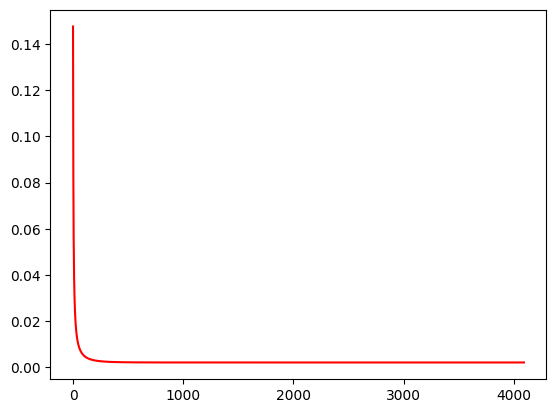

In [3]:
X_train, y_train = generate_sigmoid_regression_data(
    N=10000,
    noise_std=0.05,
    seed=123
)


X_test, y_test = generate_sigmoid_regression_data(
    N=2000,
    noise_std=0.05,
    seed=321
)

# 建立一個兩層的類神經網路
# 輸入層有 2 個特徵、隱藏層有 100 個神經元、輸出層有 3 個分類
input_layer_size = 2
hidden_layer_size = 1
output_layer_size = 1
ann = TwoLayerNN(input_layer_size, hidden_layer_size, output_layer_size)

if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)

# 使用訓練資料 X 跟標籤 y 來訓練模型
# 訓練完成後，回傳第一層與第二層的權重與偏置
W1, b1, losses = ann.train(X_train, y_train)

print("W1:")
print(W1)
print("b1:")
print(b1)

# 預測測試集
y_test_pred = ann.predict(X_test)  # shape: (N_test, 1)

# 計算測試 MSE（與訓練一致）
test_mse = np.mean((y_test_pred.flatten() - y_test) ** 2)

print("Test MSE:", test_mse)

# 繪製 loss 隨訓練次數變化的圖
plt.plot(losses, color='r')

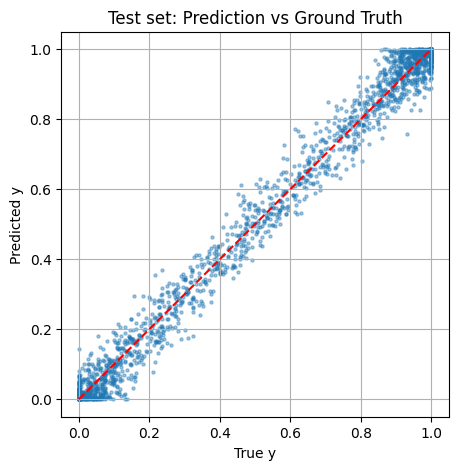

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, s=5, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Test set: Prediction vs Ground Truth")
plt.grid(True)
plt.show()

## 完整且簡單的兩層神經網路（1 個 hidden layer）

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline  # 在 Jupyter Notebook 裡直接顯示圖表

def sigmoid(z):
    # Sigmoid 啟動函數，這裡寫成數值比較穩定的版本，避免 overflow
    z = np.asarray(z, dtype=np.float64)
    return np.where(
        z >= 0,
        1.0 / (1.0 + np.exp(-z)),        # z >= 0 時的計算方式
        np.exp(z) / (1.0 + np.exp(z))   # z < 0 時的計算方式
    )

def binary_cross_entropy_loss(y_hat, y, eps=1e-12):
    """
    Binary Cross Entropy:
    L = -mean(y*log(y_hat) + (1-y)*log(1-y_hat))
    """
    y_hat = np.clip(y_hat, eps, 1.0 - eps)  # 避免 log(0)
    y = np.asarray(y, dtype=np.float64)
    return float(-np.mean(
        y * np.log(y_hat) + (1.0 - y) * np.log(1.0 - y_hat)
    ))

def max_abs(*arrays):
    # 回傳多個陣列中「最大絕對值」，常用來判斷梯度是否夠小
    return max(float(np.max(np.abs(a))) for a in arrays)

class TwoLayerNN:
    """
    簡單的兩層神經網路（1 個 hidden layer）

    Forward Model：
      X (N,n)
        -> Z1 = X W1 + b1
        -> A1 = sigmoid(Z1)
        -> Z2 = A1 W2 + b2
        -> y_hat = sigmoid(Z2)

    Backprop（搭配 MSE half loss）：
      依序把誤差從輸出層往前傳
    """
    def __init__(self, input_units, hidden_units, output_units, seed=0):
        # 設定亂數種子，方便結果重現
        rng = np.random.default_rng(seed)

        n = input_units
        h = hidden_units
        K = output_units

        # 第一層權重與 bias
        # W1: (n, h), b1: (1, h)
        self.W1 = 0.01 * rng.standard_normal((n, h))
        self.b1 = np.zeros((1, h), dtype=np.float64)

        # 第二層權重與 bias
        # W2: (h, K), b2: (1, K)
        self.W2 = 0.01 * rng.standard_normal((h, K))
        self.b2 = np.zeros((1, K), dtype=np.float64)

    def train(self, X, y, reg=0.0, iterations=10000,
              learning_rate=1e-0, epsilon=1e-8, verbose=1000):
        # 將輸入資料轉成 numpy array
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        # 如果 y 是一維，轉成 (N, K) 的形狀
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        N = X.shape[0]   # 樣本數
        losses = []     # 用來記錄每次迭代的 loss

        for i in range(1, iterations + 1):
            # ===== Forward pass =====
            Z1 = X @ self.W1 + self.b1   # 第一層線性組合
            A1 = sigmoid(Z1)             # 第一層輸出（hidden layer）

            Z2 = A1 @ self.W2 + self.b2  # 第二層線性組合
            y_hat = sigmoid(Z2)          # 最後輸出

            # 計算 loss（資料項 + L2 正則化）
            data_loss = binary_cross_entropy_loss(y_hat, y)
            reg_loss = 0.5 * reg * float(
                np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2)
            )
            loss = data_loss + reg_loss
            losses.append(loss)

            # 定期印出訓練狀況
            if verbose and (i == 1 or i % verbose == 0 or i == iterations):
                print(f"iteration {i}: loss {loss:.6f} "
                      f"(data {data_loss:.6f}, reg {reg_loss:.6f})")

            # ===== Backward pass =====
            # Binary Cross Entropy + sigmoid
            dZ2 = (y_hat - y) / N    # 直接就是 dL/dZ2

            # 第二層權重與 bias 的梯度
            dW2 = A1.T @ dZ2
            db2 = np.sum(dZ2, axis=0, keepdims=True)

            # 傳回 hidden layer
            dZ1 = (dZ2 @ self.W2.T) * (A1 * (1.0 - A1))

            # 第一層權重與 bias 的梯度
            dW1 = X.T @ dZ1
            db1 = np.sum(dZ1, axis=0, keepdims=True)

            # L2 正則化對權重的影響
            dW2 += reg * self.W2
            dW1 += reg * self.W1

            # ===== Early stop =====
            # 如果梯度已經非常小，就提早停止
            if max_abs(dW1, db1, dW2, db2) < epsilon:
                print("gradient is small enough at iter:", i)
                break

            # ===== 參數更新（Gradient Descent）=====
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2

        return (self.W1, self.b1, self.W2, self.b2, losses)

    def predict(self, X):
        # 用訓練好的模型做預測
        X = np.asarray(X, dtype=np.float64)
        Z1 = X @ self.W1 + self.b1
        A1 = sigmoid(Z1)
        Z2 = A1 @ self.W2 + self.b2
        return sigmoid(Z2)


iteration 1: loss 0.693191 (data 0.693191, reg 0.000000)
iteration 500: loss 0.338622 (data 0.338622, reg 0.000000)
iteration 1000: loss 0.337701 (data 0.337701, reg 0.000000)
iteration 1500: loss 0.337388 (data 0.337388, reg 0.000000)
iteration 2000: loss 0.337259 (data 0.337259, reg 0.000000)
iteration 2500: loss 0.337198 (data 0.337198, reg 0.000000)
iteration 3000: loss 0.337166 (data 0.337166, reg 0.000000)
iteration 3500: loss 0.337148 (data 0.337148, reg 0.000000)
iteration 4000: loss 0.337137 (data 0.337137, reg 0.000000)
iteration 4500: loss 0.337129 (data 0.337129, reg 0.000000)
iteration 5000: loss 0.337123 (data 0.337123, reg 0.000000)
W1:
[[ 1.11956358  1.04072731]
 [-1.63776479 -1.58786227]]
b1:
[[-0.18527421  0.68920648]]
W2:
[[3.96967018]
 [4.5489677 ]]
b2:
[[-4.2830594]]
Test MSE: 0.0019282364828961571


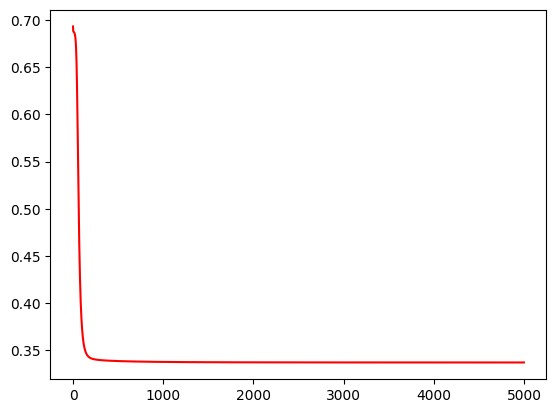

In [6]:
X_train, y_train = generate_sigmoid_regression_data(
    N=10000,
    noise_std=0.05,
    seed=123
)

X_test, y_test = generate_sigmoid_regression_data(
    N=2000,
    noise_std=0.05,
    seed=321
)

ann = TwoLayerNN(input_units=2, hidden_units=2, output_units=1, seed=0)

# X: (N,2), y: (N,) 或 (N,1)
W1, b1, W2, b2, losses = ann.train(
    X_train, y_train,
    reg=0.0,
    iterations=5000,
    learning_rate=1.0,
    verbose=500
)

print("W1:")
print(W1)
print("b1:")
print(b1)
print("W2:")
print(W2)
print("b2:")
print(b2)

# 預測測試集
y_test_pred = ann.predict(X_test)  # shape: (N_test, 1)

# 計算測試 MSE（與訓練一致）
test_mse = np.mean((y_test_pred.flatten() - y_test) ** 2)

print("Test MSE:", test_mse)

# 繪製 loss 隨訓練次數變化的圖
plt.plot(losses, color='r')

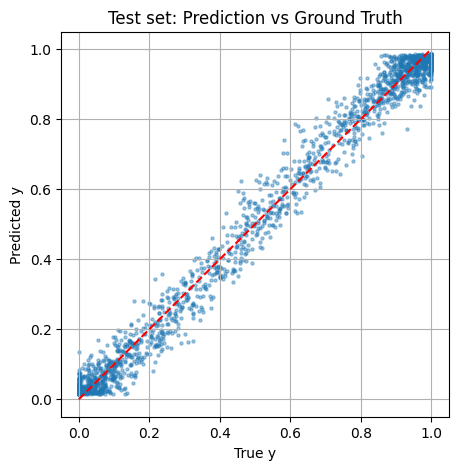

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, s=5, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Test set: Prediction vs Ground Truth")
plt.grid(True)
plt.show()

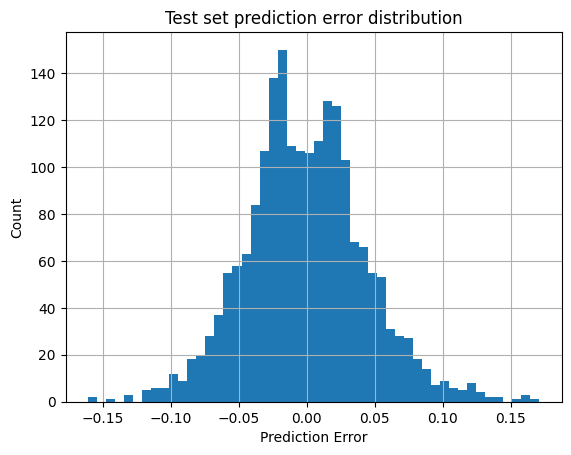

In [8]:
errors = y_test_pred.flatten() - y_test

plt.hist(errors, bins=50)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Test set prediction error distribution")
plt.grid(True)
plt.show()

In [9]:
import numpy as np

def generate_nonlinear_sigmoid_regression_data(
    N,
    quad=(1.2, -0.8),     # (alpha, beta) for x1^2, x2^2
    cross=1.0,            # gamma for x1*x2
    sin_amp=1.0,          # delta for sin term amplitude
    sin_freq=1.5,         # omega for sin frequency
    linear=(0.0, -0.5),   # (k1, k2) for linear terms on x1, x2
    bias=0.2,
    noise_std=0.05,
    seed=None
):
    """
    產生 2D 輸入、非線性 z(x) + sigmoid、連續標籤 (0~1) 的回歸資料

    Nonlinear ground truth:
      z = a*x1^2 + b*x2^2 + c*x1*x2 + d*sin(w*x1) + k1*x1 + k2*x2 + bias
      y = sigmoid(z) + noise, clipped to [0,1]

    Parameters
    ----------
    N : int
        樣本數
    quad : tuple(float, float)
        (alpha, beta) 對應 x1^2, x2^2 的係數
    cross : float
        交互項 x1*x2 係數 gamma
    sin_amp : float
        sin 項幅度 delta
    sin_freq : float
        sin 項頻率 omega
    linear : tuple(float, float)
        (k1, k2) 線性項係數
    bias : float
        截距
    noise_std : float
        高斯雜訊標準差
    seed : int or None
        random seed；None 表示使用隨機狀態

    Returns
    -------
    X : ndarray, shape (N, 2)
        輸入特徵
    y : ndarray, shape (N,)
        連續標籤（0~1）
    """
    rng = np.random.default_rng(seed)

    # inputs
    X = rng.standard_normal((N, 2))
    x1 = X[:, 0]
    x2 = X[:, 1]

    a, b = quad
    k1, k2 = linear

    # nonlinear logit
    z = (
        a * (x1 ** 2) +
        b * (x2 ** 2) +
        cross * (x1 * x2) +
        # sin_amp * np.sin(sin_freq * x1) +
        k1 * x1 +
        k2 * x2 +
        bias
    )

    # sigmoid to probability-like continuous target
    y_prob = 1.0 / (1.0 + np.exp(-z))

    # noise
    noise = rng.normal(loc=0.0, scale=noise_std, size=N)

    # final y in [0,1]
    y = np.clip(y_prob + noise, 0.0, 1.0)

    return X, y


iteration 1: loss 0.693142 (data 0.693142, reg 0.000000)
iteration 500: loss 0.681233 (data 0.681233, reg 0.000000)
iteration 1000: loss 0.681031 (data 0.681031, reg 0.000000)
iteration 1500: loss 0.680744 (data 0.680744, reg 0.000000)
iteration 2000: loss 0.680312 (data 0.680312, reg 0.000000)
iteration 2500: loss 0.679660 (data 0.679660, reg 0.000000)
iteration 3000: loss 0.678710 (data 0.678710, reg 0.000000)
iteration 3500: loss 0.677428 (data 0.677428, reg 0.000000)
iteration 4000: loss 0.675894 (data 0.675894, reg 0.000000)
iteration 4500: loss 0.674333 (data 0.674333, reg 0.000000)
iteration 5000: loss 0.672992 (data 0.672992, reg 0.000000)
W1:
[[ 0.03526847  0.04999305  0.0633461   0.03705629  0.06126383  0.04471569
   0.03557541  0.02322716 -0.00149232 -0.00661067]
 [-0.28845969 -0.41891617 -0.48372488 -0.30077397 -0.54192282 -0.34653351
  -0.19500089 -0.12065208 -0.04625012 -0.04434271]]
b1:
[[-0.00274223  0.01254496  0.02665693 -0.00192458  0.04176217  0.00224629
  -0.004942

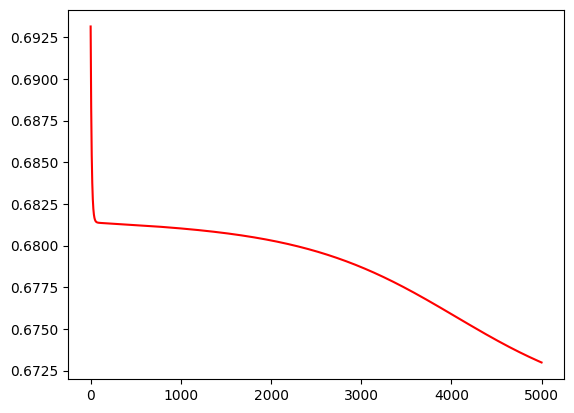

In [10]:
X_train, y_train = generate_nonlinear_sigmoid_regression_data(
    N=10000, noise_std=0.05, seed=42
)

X_test, y_test = generate_nonlinear_sigmoid_regression_data(
    N=2000, noise_std=0.05, seed=2024
)

ann = TwoLayerNN(input_units=2, hidden_units=10, output_units=1, seed=0)

# X: (N,2), y: (N,) 或 (N,1)
W1, b1, W2, b2, losses = ann.train(
    X_train, y_train,
    reg=0.0,
    iterations=5000,
    learning_rate=0.05,
    verbose=500
)

print("W1:")
print(W1)
print("b1:")
print(b1)
print("W2:")
print(W2)
print("b2:")
print(b2)

# 預測測試集
y_test_pred = ann.predict(X_test)  # shape: (N_test, 1)

# 計算測試 MSE（與訓練一致）
test_mse = np.mean((y_test_pred.flatten() - y_test) ** 2)

print("Test MSE:", test_mse)

# 繪製 loss 隨訓練次數變化的圖
plt.plot(losses, color='r')

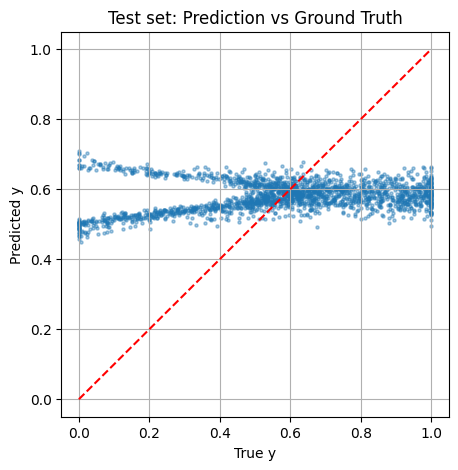

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, s=5, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Test set: Prediction vs Ground Truth")
plt.grid(True)
plt.show()